In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm

In [4]:
subject_id_default = 13620
dataloader = utils.MRIDataLoader()
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
info_dict = dataloader.get_info_dict()
thresh_default = 0.9
subject_ids = dataloader.get_subject_ids()
is_pre_term = dataloader.get_info(1) < 26
pre_term_ids = np.arange(subject_ids.shape[0])[is_pre_term]
full_term_ids = np.arange(subject_ids.shape[0])[~is_pre_term]
root_path = 'data/arrays/'

try loading all roi over thresh data

### Get estimate on T2 for WM, GM, CSF using Bootstrap on only Full Term subjects

nb_sample = 100
nb_bootstrap



In [6]:
roi_data_all, roi_seg_all = dataloader.load_all_roi_thresh_data(thresh_default, subject_names='all')

No File exists - Creating Data...


 21%|##1       | 29/135 [01:02<03:23,  1.92s/it]

In [5]:
roi_data_full[0].shape

(3937995, 10)

In [6]:
nb_sample = 100
nb_bootstrap = 200

rois = ['WM', 'GM', 'CSF']
roi_bounds = {'WM': [(2000, 15000), (20, 150)],
          'GM': [(2000, 15000), (20, 150)],
          'CSF': [(2000, 15000), (20, 2000)]}
roi_T2_1 = {}
rmse_1 = {}
x0 = np.array([5000, 50])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_1[roi] = []
    rmse_1[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_full[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_full[roi_id][sample_ids,:]
        seg = roi_seg_full[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        # v0 = seg[:,1:].max(axis=-1)
        # v0 = np.where(v0 < 0.5, 0.5, v0)
        # v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:]]
        bounds = roi_bounds[roi]
        
        problem_one_compartment = utils.create_problem_to_minimize('one_compartment', bounds=bounds)
        S0, T2 = utils.minimize_given_problem(problem=problem_one_compartment, X0=X0, args_list=args, is_print_progress=False)
        roi_T2_1[roi].append(T2.mean())
        
        signal_est = utils.model_one_compartment(T2, S0, TE_times)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_1[roi].append(rmse)
    roi_T2_1[roi] = np.stack(roi_T2_1[roi], axis=0)
    rmse_1[roi] = np.array(rmse_1[roi])

Calculating WM...


100%|##########| 200/200 [02:20<00:00,  1.42it/s]


Calculating GM...


100%|##########| 200/200 [02:19<00:00,  1.43it/s]


Calculating CSF...


100%|##########| 200/200 [02:33<00:00,  1.30it/s]


In [7]:
nb_sample = 100
nb_bootstrap = 200

rois = ['WM', 'GM', 'CSF']
roi_bounds = {'WM': [(2000, 15000), (20, 100), (20,2000)],
          'GM': [(2000, 15000), (20, 100), (20,2000)],
          'CSF': [(2000, 15000), (50, 2000), (20,2000)]}
roi_T2_2 = {}
rmse_2 = {}
x0 = np.array([5000, 50, 60])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_2[roi] = []
    rmse_2[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_full[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_full[roi_id][sample_ids,:]
        seg = roi_seg_full[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        v0 = seg[:,1:].max(axis=-1)
        v0 = np.where(v0 < 0.5, 0.5, v0)
        v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:], v]
        bounds = roi_bounds[roi]
        
        problem_two_compartment = utils.create_problem_to_minimize('two_compartment', bounds=bounds)
        S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_print_progress=False)
        T2 = np.array([T2_0.mean(), T2_1.mean()])
        roi_T2_2[roi].append(T2)
        
        signal_est = utils.model_multi_compartment(np.stack([T2_0, T2_1], axis=-1), S0, TE_times, v)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_2[roi].append(rmse)
    roi_T2_2[roi] = np.stack(roi_T2_2[roi], axis=0)
    rmse_2[roi] = np.array(rmse_2[roi])

Calculating WM...


100%|##########| 200/200 [03:13<00:00,  1.03it/s]


Calculating GM...


100%|##########| 200/200 [03:34<00:00,  1.07s/it]


Calculating CSF...


100%|##########| 200/200 [03:08<00:00,  1.06it/s]


NameError: name 'roi_T2' is not defined

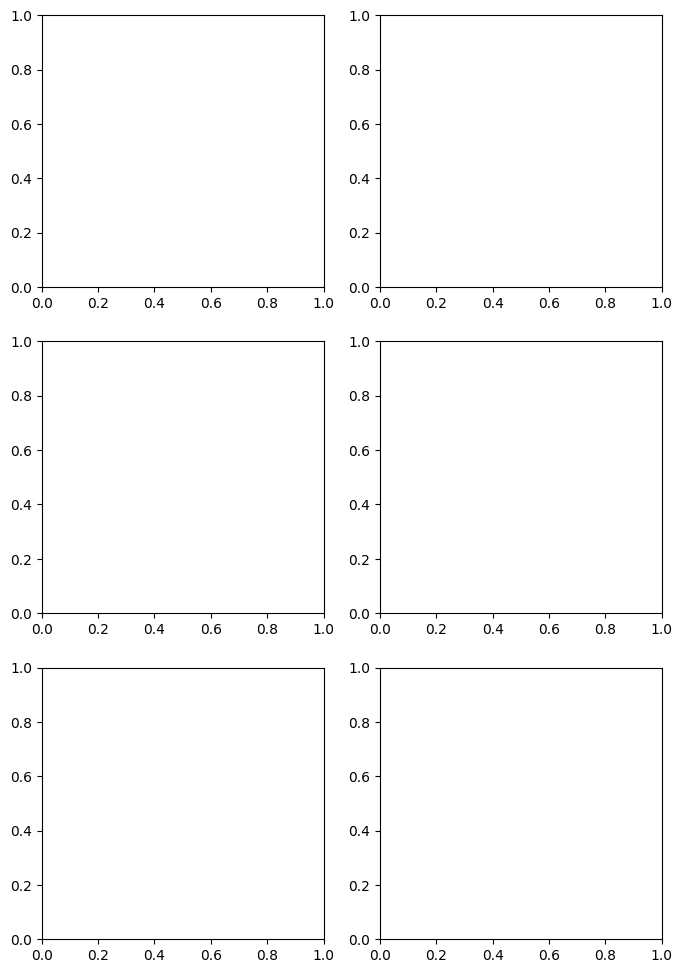

In [8]:
fig, axs = plt.subplots(len(rois),2, figsize=(8, 12))
for row, roi in enumerate(rois):
    roi_id = roi_dict[roi]
    T2_1 = roi_T2_1[roi]
    T2_2 = roi_T2_2[roi]
    rmse1 = rmse_1[roi]
    rmse2 = rmse_2[roi]
    axs[row, 0].hist(T2_1, label='1', alpha=0.5)
    axs[row, 0].hist(T2_2[:,0], label='2', alpha=0.5)
    axs[row, 0].set_title(f'{roi} - T2')
    axs[row, 1].hist(rmse1, label='1', alpha=0.5)
    axs[row, 1].hist(rmse2, label='2', alpha=0.5)
    axs[row, 1].set_title(f'{roi} - RMSE')
    if row == 1:
        axs[row,0].legend()
fig.tight_layout()

### Now do it on pre-term

In [ ]:
roi_data_pre, roi_seg_pre = dataloader.load_all_roi_thresh_data(thresh_default, is_only_preterm=True, is_only_fullterm=False)

In [ ]:
nb_sample = 100
nb_bootstrap = 200

rois = ['WM', 'GM', 'CSF']
roi_bounds = {'WM': [(2000, 15000), (20, 150)],
          'GM': [(2000, 15000), (20, 150)],
          'CSF': [(2000, 15000), (20, 2000)]}
roi_T2_1_pre = {}
rmse_1_pre = {}
x0 = np.array([5000, 50])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_1_pre[roi] = []
    rmse_1_pre[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_pre[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_pre[roi_id][sample_ids,:]
        seg = roi_seg_pre[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        # v0 = seg[:,1:].max(axis=-1)
        # v0 = np.where(v0 < 0.5, 0.5, v0)
        # v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:]]
        bounds = roi_bounds[roi]
        
        problem_one_compartment = utils.create_problem_to_minimize('one_compartment', bounds=bounds)
        S0, T2 = utils.minimize_given_problem(problem=problem_one_compartment, X0=X0, args_list=args, is_print_progress=False)
        roi_T2_1_pre[roi].append(T2.mean())
        
        signal_est = utils.model_one_compartment(T2, S0, TE_times)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_1_pre[roi].append(rmse)
    roi_T2_1_pre[roi] = np.stack(roi_T2_1_pre[roi], axis=0)
    rmse_1_pre[roi] = np.array(rmse_1_pre[roi])

Calculating WM...


100%|##########| 200/200 [02:22<00:00,  1.40it/s]


Calculating GM...


100%|##########| 200/200 [02:18<00:00,  1.45it/s]


Calculating CSF...


100%|##########| 200/200 [02:37<00:00,  1.27it/s]


In [ ]:
nb_sample = 100
nb_bootstrap = 200

rois = ['WM', 'GM', 'CSF']
roi_bounds = {'WM': [(2000, 15000), (20, 100), (20,2000)],
          'GM': [(2000, 15000), (20, 100), (20,2000)],
          'CSF': [(2000, 15000), (50, 2000), (20,2000)]}
roi_T2_2_pre = {}
rmse_2_pre = {}
x0 = np.array([5000, 50, 60])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_2_pre[roi] = []
    rmse_2_pre[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_pre[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_pre[roi_id][sample_ids,:]
        seg = roi_seg_pre[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        v0 = seg[:,1:].max(axis=-1)
        v0 = np.where(v0 < 0.5, 0.5, v0)
        v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:], v]
        bounds = roi_bounds[roi]
        
        problem_two_compartment = utils.create_problem_to_minimize('two_compartment', bounds=bounds)
        S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_print_progress=False)
        T2 = np.array([T2_0.mean(), T2_1.mean()])
        roi_T2_2_pre[roi].append(T2)
        
        signal_est = utils.model_multi_compartment(np.stack([T2_0, T2_1], axis=-1), S0, TE_times, v)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_2_pre[roi].append(rmse)
    roi_T2_2_pre[roi] = np.stack(roi_T2_2_pre[roi], axis=0)
    rmse_2_pre[roi] = np.array(rmse_2_pre[roi])

Calculating WM...


100%|##########| 200/200 [03:13<00:00,  1.03it/s]


Calculating GM...


100%|##########| 200/200 [03:44<00:00,  1.12s/it]


Calculating CSF...


100%|##########| 200/200 [03:22<00:00,  1.01s/it]


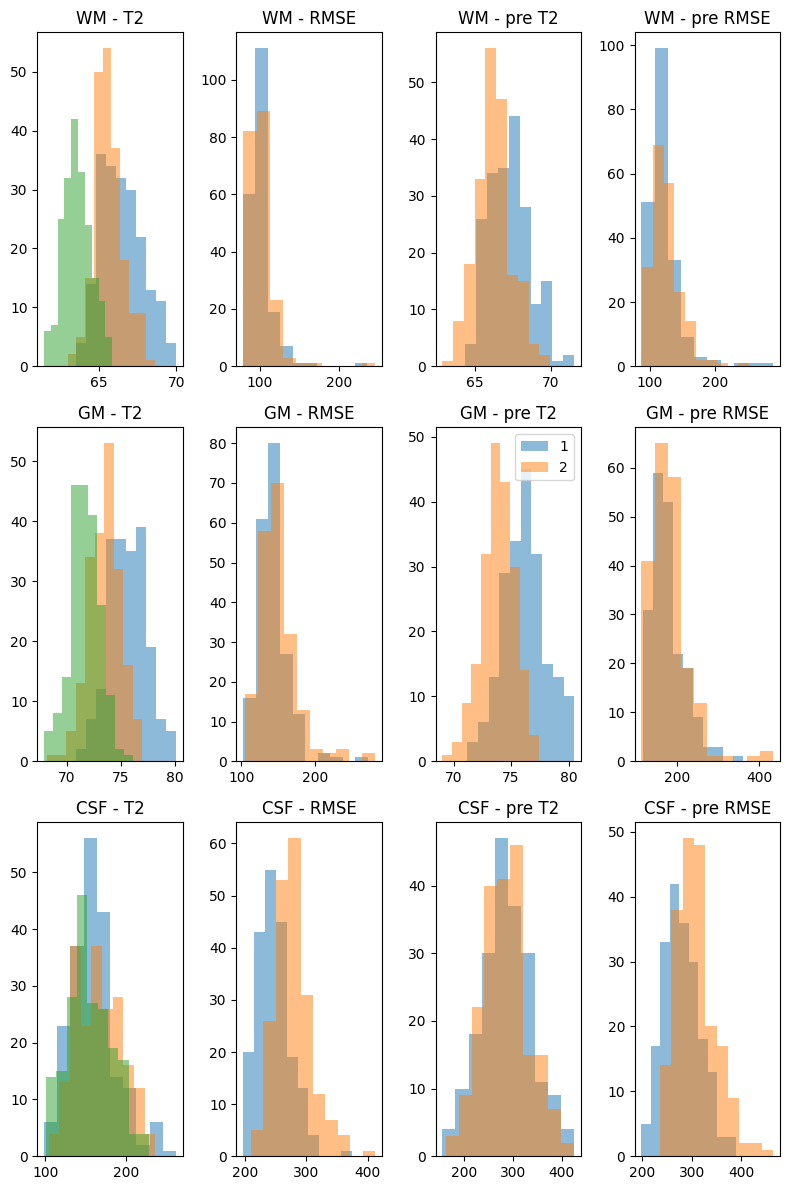

In [ ]:
fig, axs = plt.subplots(len(rois),4, figsize=(8, 12))
for row, roi in enumerate(rois):
    roi_id = roi_dict[roi]
    T2_1 = roi_T2_1[roi]
    T2_2 = roi_T2_2[roi]
    T2_10 = roi_T2[roi]
    rmse1 = rmse_1[roi]
    rmse2 = rmse_2[roi]
    axs[row, 0].hist(T2_1, label='1', alpha=0.5)
    axs[row, 0].hist(T2_2[:,0], label='2', alpha=0.5)
    axs[row, 0].hist(T2_10[:,0], label='2-10', alpha=0.5)
    axs[row, 0].set_title(f'{roi} - T2')
    axs[row, 1].hist(rmse1, label='1', alpha=0.5)
    axs[row, 1].hist(rmse2, label='2', alpha=0.5)
    axs[row, 1].set_title(f'{roi} - RMSE')
    
    
    roi_id = roi_dict[roi]
    T2_1 = roi_T2_1_pre[roi]
    T2_2 = roi_T2_2_pre[roi]
    rmse1 = rmse_1_pre[roi]
    rmse2 = rmse_2_pre[roi]
    axs[row, 2].hist(T2_1, label='1', alpha=0.5)
    axs[row, 2].hist(T2_2[:,0], label='2', alpha=0.5)
    axs[row, 2].set_title(f'{roi} - pre T2')
    axs[row, 3].hist(rmse1, label='1', alpha=0.5)
    axs[row, 3].hist(rmse2, label='2', alpha=0.5)
    axs[row, 3].set_title(f'{roi} - pre RMSE')
    if row == 1:
        axs[row,2].legend()
fig.tight_layout()